In [45]:
from Basefolder import basefolder
import time
import numpy as np
import pandas as pd
from Finder_1d import Finder_1d
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import seaborn as sns
from sklearn.cluster import DBSCAN
from Clustering_CAML import Clustering_CAML
import h5py
from DbscanLoop import DbscanLoop
from sklearn.neighbors import NearestNeighbors
import pickle
import scipy.stats as stats
#import feather
#import pyarrow.feather as feather
#import rpy2.robjects as ro
#from rpy2.robjects import pandas2ri
#from rpy2.robjects.conversion import localconverter

#from rpy2.robjects import pandas2ri
#from rpy2.robjects.conversion import localconverter
#from rpy2.robjects.conversion import localconverter

pd.options.mode.chained_assignment = None  # default='warn'

In [46]:
def PlotScatter(XC_,labels=[],ax=[]):

    if(len(labels)==0):
        labels = -1*np.ones((len(XC_),));
 
    if(ax==[]):
        fig,ax = plt.subplots(1,1,figsize=(6,6)); 
       
    mark_ = (labels==-1);
    ax.scatter(x=XC_[mark_,0],y=XC_[mark_,1],s=.4,c='grey',alpha=0.1);

    mark_ = (labels>=0);
    sns.scatterplot(x=XC_[mark_,0],y=XC_[mark_,1],hue=labels[mark_],palette='deep',linewidth=0,
                    s=2,legend=False,ax=ax);
    ax.set_aspect('equal');
#    plt.savefig(outputfolder+"results_"+analysis_name+"_"+filename_add+".pdf",bbox_inches="tight");

In [47]:
def LoadPoints(filename,datascale=1):
    if(filename[-3:]=="txt"):
        XC = np.loadtxt(filename);
    elif(filename[-4:]=="hdf5"):
        f             = h5py.File(filename, 'r')    
        dset          = f['locs'];
        XC            = np.stack((dset["x"],dset["y"])).T    
        
    XC        = np.unique(XC,axis=0);
    XC        = datascale*XC;
        
    return XC;

def FilterPoints(XC,xmin,xmax,ymin,ymax):
    mask = (XC[:,0]>xmin)*(XC[:,0]<xmax)*(XC[:,1]>ymin)*(XC[:,1]<ymax);
    return XC[mask,:];

In [48]:
def GetLineOfOptima(df,x_selector,y_selector,no_bins=0):
    
    x_sel      = df[x_selector];
    x_sel_sort = np.sort(np.unique(x_sel));
    
    if(no_bins == 0):
        bins = np.asarray([np.min(x_sel)-1]+list((x_sel_sort[:-1]+x_sel_sort[1:])/2)+[np.max(x_sel)+1]);
        no_bins = len(bins)-1;
    else:
        bins = np.linspace(0.99*np.min(x_sel),np.max(x_sel)*1.01,no_bins+1);
    print(np.unique(df[x_selector]));    

    xs = -1*np.ones((no_bins,1),dtype=int);
    idxs = [];
    
    for i in np.arange(no_bins):
        mark_    = (df[x_selector] > bins[i])&(df[x_selector] <= bins[i+1]);
        if(np.sum(mark_)==0):
            continue;
        else:
            idxs.append((df.loc[mark_,y_selector]).idxmax());
        
    df_opt             = pd.DataFrame();
    df_opt['idx']      = idxs;
    for c in df.columns:
        df_opt[c] = np.asarray(df.loc[idxs,c]);

    return df_opt;

In [49]:
def GetLineOfOptimaUnique(df,x_selector,y_selector,no_bins=0):
    
    x_sel_sort = np.sort(np.unique(df[x_selector]));    
    idxs       = [];
    
    for x_sel in x_sel_sort:
        mark_    = (df[x_selector] == x_sel);
        if(np.sum(mark_)==0):
            continue;
        else:
            idxs.append((df.loc[mark_,y_selector]).idxmax());
        
    df_opt             = pd.DataFrame();
    df_opt['idx']      = idxs;
    for c in df.columns:
        df_opt[c] = np.asarray(df.loc[idxs,c]);

    return df_opt;

In [50]:
def GetClusterDistribution(labels):
    cl_sizes = [];
    for c in np.unique(labels):
        if(c == -1):
            continue;
        cl_sizes.append(np.sum(labels==c));
    return cl_sizes;

# Parameters and Load points

In [51]:
if(True):
    mainfolder     = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/ProteinData_ttx_1hr_2/';
    outputfolder   = mainfolder + 'ReferenceCheck/';
    analysis_name  = "dataWindow_2";
    image_filename = "AHA_2_MMStack_Pos0.ome_locs_render_driftcor_filter_render_pix0.02X6f20";

    XC        = LoadPoints(mainfolder+image_filename+'.hdf5',datascale=158);    
    XC_signal = FilterPoints(XC,22000,27000,22000,27000);
    XC_noise  = FilterPoints(XC,60000,70000,50000,60000);

elif(False):
    mainfolder       = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/MikeData/';
    outputfolder     = mainfolder + 'ReferenceCheck/';
    outputfolder_R   = mainfolder + 'Output_R/';
    image_filename   = 'EGFR-P1-ATTO655_cell_2_MMImages.ome_locs_render_al_linked1sigma_X';
    
    if(True):
        analysis_name = "dataWindow_1";    
        algo          = "DbscanLoop"
    else:    
        analysis_name = "dataWindow_1_dbscan";    
        algo          = "dbscan"
    
    XC_noise     = LoadPoints(mainfolder+image_filename+'_noise.txt');
    XC_signal    = LoadPoints(mainfolder+image_filename+'_signal.txt');    
    
    XC_noise  = FilterPoints(XC_noise,50,60,50,60)
    XC_signal = FilterPoints(XC_signal,100,110,150,160)    
    #Define window to analyse
    
np.savetxt(outputfolder+analysis_name+"_filtered_noise.txt",XC_noise,fmt="%f\t%f");
np.savetxt(outputfolder+analysis_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    

In [52]:
#XC_noise     = LoadPoints(mainfolder+'EGFR-P1-ATTO655_cell_2_MMImages.ome_locs_render_al_linked1sigma_X_noise.txt');
#XC_noise  = FilterPoints(XC_noise,60,80,60,80)

# Load or compute clustering

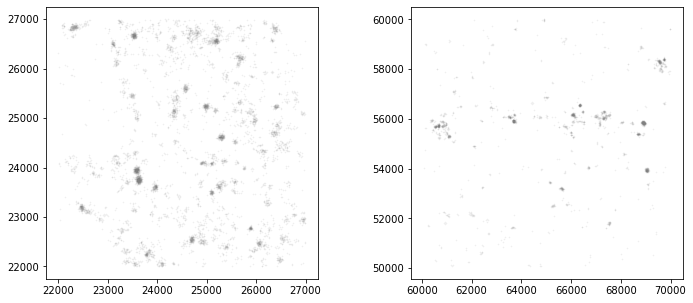

In [53]:
fig,axs = plt.subplots(1,2,figsize=(12,5));
PlotScatter(XC_signal,ax=axs[0])
PlotScatter(XC_noise,ax=axs[1])

In [54]:
if(False):
    FD      = Finder_1d(algo=algo);
    labels  = FD.fit(XC_signal);    
    
    FD_ref      = Finder_1d(algo=algo);
    labels_ref  = FD_ref.fit(XC_noise,XC_signal);    
    
    with open(outputfolder+"results_"+analysis_name+'.pickle','wb') as handle:
        pickle.dump({'FD':FD,'FD_ref':FD_ref}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
else:
    with open(outputfolder+'results_'+analysis_name+'.pickle', 'rb') as fr:
        FD_load = pickle.load(fr);
    FD     = FD_load['FD'];
    FD_ref = FD_load['FD_ref'];

# Save for input in R 

In [55]:
#Save phasespace in csv
FD_all1 = (FD.phasespace);
FD_all1['type'] = 'signal';

FD_all2         = (FD_ref.phasespace);
FD_all2['type'] = 'noise';

(FD_all1.append(FD_all2,ignore_index=True)).to_csv(outputfolder_R+'results_'+analysis_name+'.csv');
#(FD.phasespace).to_csv(outputfolder+'results_phasespace'+analysis_name+'.csv');

In [56]:
L = np.zeros((len((FD.phasespace).loc[1,'labels']),len(FD.phasespace)),dtype=np.int32)
for i,d in enumerate(FD.phasespace['labels']):
    L[:,i] = d;
np.savetxt(outputfolder_R+analysis_name+"_labels_signal.txt",L,fmt="%d",delimiter='\t',newline='\n');    

In [57]:
L = np.zeros((len((FD_ref.phasespace).loc[1,'labels']),len(FD_ref.phasespace)),dtype=np.int32)
for i,d in enumerate(FD_ref.phasespace['labels']):
    L[:,i] = d;
np.savetxt(outputfolder_R+analysis_name+"_labels_noise.txt",L,fmt="%d",delimiter='\t',newline='\n');    

In [58]:
np.savetxt(outputfolder_R+analysis_name+"_filtered_noise.txt",XC_noise,fmt="%f\t%f");
np.savetxt(outputfolder_R+analysis_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    

In [59]:
cls_distribution = [];
ind = np.zeros((0,),dtype=int);
for i,d in enumerate(FD.phasespace['labels']):
    d_ = GetClusterDistribution(d);
    cls_distribution += (d_);
    ind = np.concatenate((ind,i*np.ones_like(d_,dtype=int)))
    
cls_d = pd.DataFrame();
cls_d['size'] = cls_distribution
cls_d['index'] = (ind);
cls_d.to_csv(outputfolder_R+analysis_name+"_clusterSizes.txt")

In [60]:
#with open(outputfolder_R+analysis_name+"_clusterSizes.txt", "w") as txt_file:
#    for i,d in enumerate(FD.phasespace['labels']):
#        d_ = GetClusterDistribution(d);
#        txt_file.write(' '.join(str(x) for x in d_)+'\n') # works with any number of el

# Analysis

In [61]:
#Select a clustering:
df1     = FD.phasespace[['sigma', 'threshold','similarityScore','no_clusters']]
df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore','no_clusters']]
df1['similarityScore_ref'] = df1_ref['similarityScore'];
df1['similarityScore_ref_ratio'] = (df1_ref['similarityScore'])/(df1['similarityScore']);

df1['no_clusters_ref'] = df1_ref['no_clusters'];
df1['no_clusters_ref_ratio'] = (df1_ref['no_clusters'])/(df1['no_clusters']);

df_opt_sim = GetLineOfOptima(df1,'similarityScore_ref','similarityScore',15)
df_opt_cl = GetLineOfOptima(df1,'no_clusters_ref','no_clusters',15)

if(False):
    limit_noise_to_signal = 0.4;
    
    # (1) based on number of clusters
    mark_ = (df1['similarityScore_ref_ratio'] < limit_noise_to_signal);
    idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
#    print(df1.loc[idx_similarityScore,:])

    # (1) based on number of clusters
    mark_ = (df1['no_clusters_ref_ratio'] < limit_noise_to_signal);
    idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
#    print(df1.loc[idx_no_clusters,:])
else:
    limit_noise_no_cluster = 4;    
    limit_noise_similarity = 320;
        
    # (1) based on number of clusters
    mark_ = (df1['similarityScore_ref'] < limit_noise_similarity);
    idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
#    print(df1.loc[idx_similarityScore,:])

    # (1) based on number of clusters
    mark_ = (df1['no_clusters_ref'] < limit_noise_no_cluster);
    idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
#    print(df1.loc[idx_no_clusters,:])

[0.000e+00 3.000e+00 6.000e+00 7.000e+00 9.000e+00 1.100e+01 1.400e+01
 2.300e+01 4.200e+01 4.800e+01 4.900e+01 5.400e+01 6.400e+01 7.000e+01
 1.570e+02 1.950e+02 2.340e+02 2.970e+02 3.060e+02 4.250e+02 4.260e+02
 4.690e+02 4.870e+02 5.110e+02 5.440e+02 5.760e+02 6.020e+02 6.200e+02
 7.040e+02 7.280e+02 7.360e+02 7.490e+02 7.610e+02 7.900e+02 7.930e+02
 8.200e+02 8.340e+02 8.730e+02 9.010e+02 9.030e+02 9.170e+02 9.200e+02
 9.570e+02 9.730e+02 9.880e+02 9.920e+02 9.930e+02 9.950e+02 1.011e+03
 1.021e+03 1.030e+03 1.033e+03 1.066e+03 1.111e+03 1.185e+03 1.199e+03
 1.222e+03 1.224e+03 1.236e+03 1.238e+03 1.259e+03 1.263e+03 1.270e+03
 1.321e+03 1.372e+03 1.374e+03 1.380e+03 1.388e+03 1.396e+03 1.422e+03
 1.425e+03 1.435e+03 1.439e+03 1.442e+03 1.466e+03 1.486e+03 1.498e+03
 1.524e+03 1.538e+03 1.550e+03 1.556e+03 1.559e+03 1.562e+03 1.563e+03
 1.566e+03 1.568e+03 1.577e+03 1.590e+03 1.601e+03 1.606e+03 1.610e+03
 1.617e+03 1.621e+03 1.626e+03 1.631e+03 1.632e+03 1.638e+03 1.640e+03
 1.644

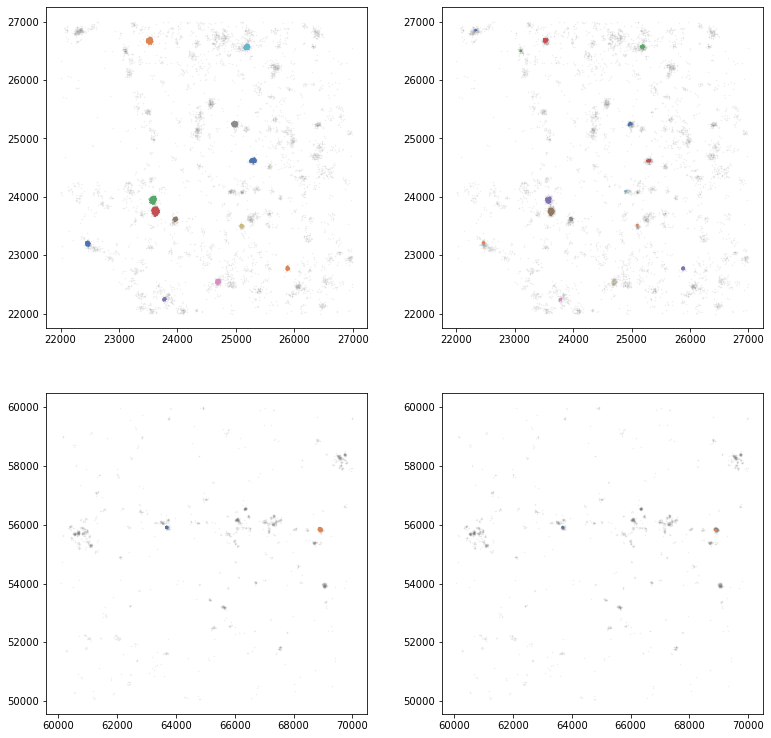

In [62]:
fig,axs = plt.subplots(2,2,figsize=(13,13)); 
PlotScatter(XC_signal,FD.phasespace.loc[idx_similarityScore,'labels'],ax=axs[0,0])
PlotScatter(XC_signal,FD.phasespace.loc[idx_no_clusters,'labels'],ax=axs[0,1])

PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_similarityScore,'labels'],ax=axs[1,0])
PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_no_clusters,'labels'],ax=axs[1,1])

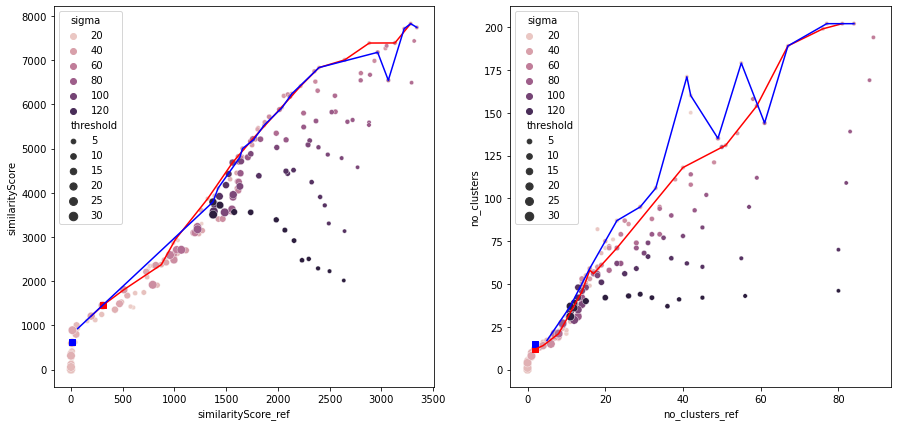

In [63]:

fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='similarityScore_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
sns.lineplot(data=df_opt_sim,x='similarityScore_ref',y="similarityScore",color='r',ax=ax)
sns.lineplot(data=df_opt_cl,x='similarityScore_ref',y="similarityScore",color='b',ax=ax)

ax      = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
sns.lineplot(data=df_opt_sim,x='no_clusters_ref',y="no_clusters",ax=ax,color='r')
sns.lineplot(data=df_opt_cl,x='no_clusters_ref',y="no_clusters",ax=ax,color='b')

#ax.set_xlim(-10,2000);
#ax.set_xlim(0,30);


In [64]:
df1

,sigma,threshold,similarityScore,no_clusters,similarityScore_ref,similarityScore_ref_ratio,no_clusters_ref,no_clusters_ref_ratio
0,14.074268,3.0,3300.0,150,1263.0,0.382727,42,0.280000
1,14.074268,4.0,2288.0,71,749.0,0.327360,20,0.281690
2,14.074268,5.0,1404.0,31,602.0,0.428775,10,0.322581
3,14.074268,6.0,991.0,21,70.0,0.070636,10,0.476190
4,14.074268,7.0,617.0,17,42.0,0.068071,6,0.352941
...,...,...,...,...,...,...,...,...
205,133.455245,16.0,3564.0,40,1577.0,0.442480,15,0.375000
206,133.455245,18.0,3710.0,39,1442.0,0.388679,12,0.307692
207,133.455245,22.0,3719.0,36,1439.0,0.386932,12,0.333333
208,133.455245,25.0,3790.0,37,1372.0,0.362005,11,0.297297


[ 3.  4.  5.  6.  7.  8.  9. 11. 13. 16. 18. 22. 25. 30.]


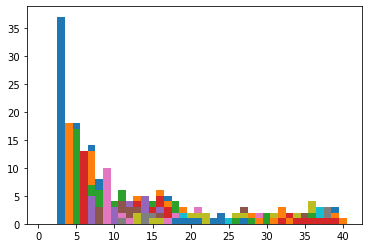

In [65]:
df_opt_th = GetLineOfOptima(df1,'threshold','similarityScore')

cl_dist = [];
idxs = [];
thresholds = [];

for index, row in df_opt_th.iterrows():
    df1_row     = FD.phasespace.loc[int(row['idx']),:];
    cld         = GetClusterDistribution(df1_row['labels']);
    cl_dist    += (list(cld));
    idxs       += list((int(row['idx']))*np.ones_like(cld));
    thresholds += list(df1_row['threshold']*np.ones_like(cld));

df_clusterSizes = pd.DataFrame();
df_clusterSizes['clusterSize'] = cl_dist;
df_clusterSizes['threshold']   = thresholds;

th_ = [];
cv_ = [];
fano_ = [];
kur_ = [];
skew_ = [];
max_cl = [];
m_ = [];
med_ = [];
v1_ = [];

for t in np.unique(df_clusterSizes['threshold']):#df_clusterSizes.iterrows():
    d_ = df_clusterSizes.loc[df_clusterSizes['threshold']==t,'clusterSize'];
    cv_.append(stats.variation(d_));
    m_.append(np.mean(d_));
    med_.append(np.median(d_));    
    th_.append(t);
    fano_.append(np.var(d_)/np.mean(d_));
    kur_.append(stats.kurtosis(d_));                            
    skew_.append(stats.skew(d_));    
    
    
    z_ = plt.hist(d_,bins=np.linspace(0,40,41)+0.5);
    idx_max = np.argmax(z_[0]);    
    max_cl.append(z_[1][idx_max]+0.5);
                
    dv_ = d_.value_counts().sort_index();    
    v1 = np.sum(dv_[(dv_.index < t+1)]);#/np.sum(dv_[(dv_.index < t+3)]);
#    v1 = np.sum(dv_[(dv_.index < t+2)])/np.sum(dv_[(dv_.index >= t+2)*(dv_.index < t+4)]);    
    v1_.append(v1);

    
#    v1.append(np.sum(dv_[(dv_.index < th+1)])/np.sum(dv_[(dv_.index < th+3)]));

    
df_stats_per_th = pd.DataFrame();
df_stats_per_th['mean'] = m_;
df_stats_per_th['median'] = med_;
df_stats_per_th['cv'] = cv_;
df_stats_per_th['threshold']   = th_;
df_stats_per_th['fano']   = fano_;
df_stats_per_th['skewness']   = skew_;
df_stats_per_th['kurtosis']   = kur_;
df_stats_per_th['max_cl']   = max_cl;
df_stats_per_th['v1']   = v1_;

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


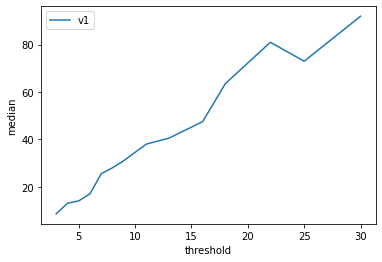

In [67]:
sns.lineplot(df_stats_per_th['threshold'],df_stats_per_th['meadian'],label='v1');
#plt.ylim(0,40)

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


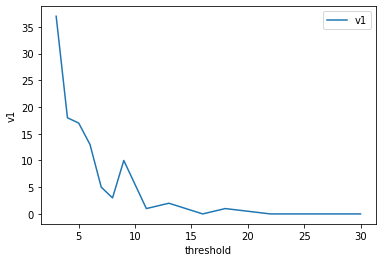

In [81]:
sns.lineplot(df_stats_per_th['threshold'],df_stats_per_th['v1'],label='v1');
#plt.plot([0,40],[0,40]);

In [82]:
# Analysis: Did we reach a plateau?
def Plateau_analysis(x,y):    
    x =np.asarray(x);
    y =np.asarray(y);    
    
    y = 0.5*(y[1:]+y[:-1]);
    x = 0.5*(x[1:]+x[:-1]);    
    
    dydx = (y[1:]-y[:-1])/(x[1:]-x[:-1]);
#    print(dydx)
#    print(y)
    plt.plot(x[1:],dydx/y[0],'r');
#    plt.plot(x,y,'b');

(0.0, 20.0)

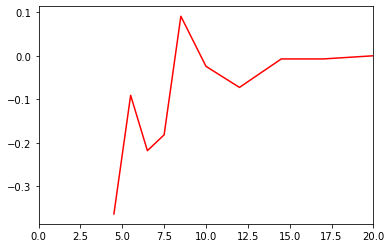

In [83]:
Plateau_analysis(df_stats_per_th['threshold'],df_stats_per_th['v1'])
plt.xlim(0,20)

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

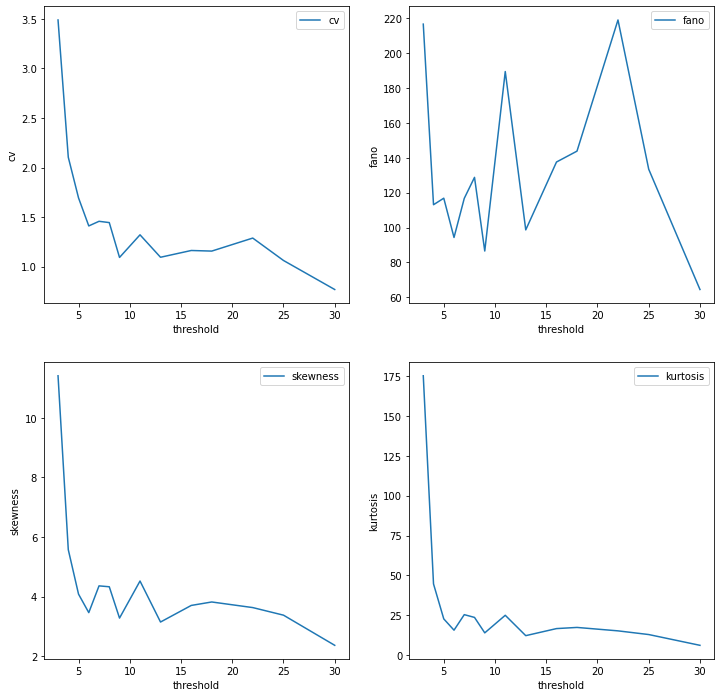

In [29]:
fig,axs = plt.subplots(2,2,figsize=(12,12)); 
sns.lineplot(df_stats_per_th['threshold'],df_stats_per_th['cv'],label='cv',ax=axs[0,0]);
sns.lineplot(df_stats_per_th['threshold'],df_stats_per_th['fano'],label='fano',ax=axs[0,1]);
sns.lineplot(df_stats_per_th['threshold'],df_stats_per_th['skewness'],label='skewness',ax=axs[1,0]);
sns.lineplot(df_stats_per_th['threshold'],df_stats_per_th['kurtosis'],label='kurtosis',ax=axs[1,1]);

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


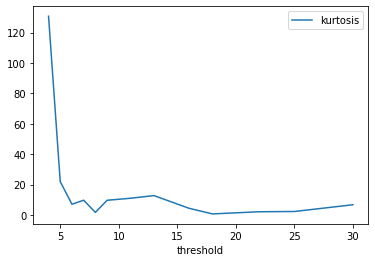

In [30]:
z = df_stats_per_th['kurtosis'];
sns.lineplot(df_stats_per_th['threshold'][1:],np.abs(np.asarray(z[1:])-np.asarray(z[:-1])),label='kurtosis');

In [31]:
np.arange(np.max(df_clusterSizes['threshold']))

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

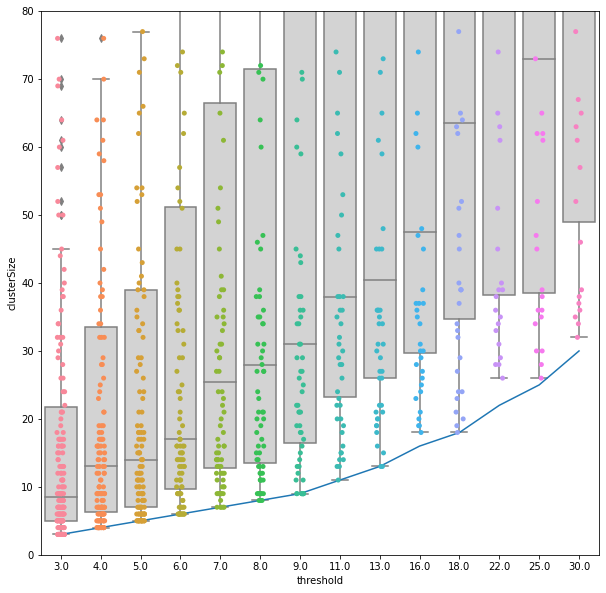

In [72]:
fig,axs = plt.subplots(1,1,figsize=(10,10)); 
sns.stripplot(data=df_clusterSizes,y='clusterSize',x='threshold',ax=axs)
sns.boxplot(data=df_clusterSizes,y='clusterSize',x='threshold',ax=axs,color='lightgrey')
axs.set_ylim(0,80)
plt.plot(np.arange(len(np.unique(df_clusterSizes['threshold']))),np.unique(df_clusterSizes['threshold']))

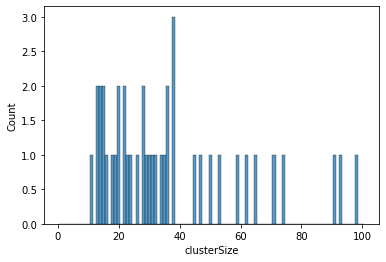

In [73]:
sns.histplot(df_clusterSizes.loc[df_clusterSizes['threshold']==11,'clusterSize'],bins=np.linspace(0,100,101)+0.5)

[ 3.  4.  5.  6.  7.  8.  9. 11. 13. 16. 18. 22. 25. 30.]


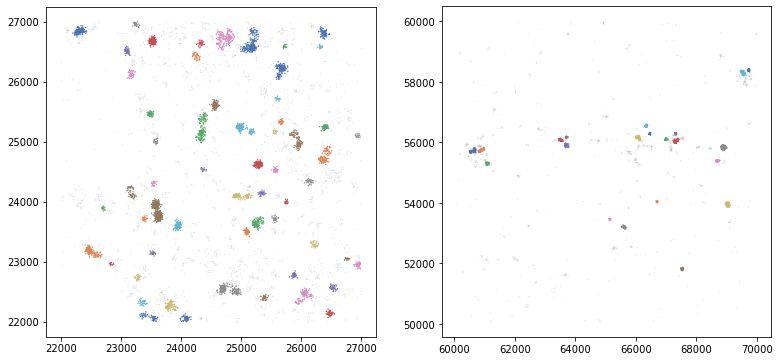

In [77]:
df_opt_th = GetLineOfOptima(df1,'threshold','similarityScore')

idx_ = int(df_opt_th.loc[df_opt_th['threshold']==11,'idx'])

fig,axs = plt.subplots(1,2,figsize=(13,8)); 
PlotScatter(XC_signal,FD.phasespace.loc[idx_,'labels'],ax=axs[0])
#PlotScatter(XC_signal,FD.phasespace.loc[133,'labels'],ax=axs[1])
PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_,'labels'],ax=axs[1])

In [ ]:
df_opt_th = GetLineOfOptima(df1,'threshold','similarityScore')
df_opt_th_ncl = GetLineOfOptima(df1,'threshold','no_clusters')

fig,axs = plt.subplots(3,3,figsize=(14,14));

ax = axs[0,0];
ax.plot(df_opt_th['sigma'],df_opt_th['threshold']);
sns.scatterplot(x=df_opt_th['sigma'],y=df_opt_th['threshold'],hue=df_opt_th['no_clusters_ref_ratio'],s=100,ax=ax);

ax.plot(df_opt_th_ncl['sigma'],df_opt_th_ncl['threshold'],'r');
sns.scatterplot(x=df_opt_th_ncl['sigma'],y=df_opt_th['threshold'],hue=df_opt_th['no_clusters_ref_ratio'],\
                s=100,ax=ax,palette='Reds');

ax.set_xlim(np.min(df1['sigma']),np.max(df1['sigma']))
ax.set_ylim(np.min(df1['threshold']),np.max(df1['threshold']))

ax = axs[0,1];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore_ref_ratio',ax=ax);
sns.lineplot(data=df_opt_th_ncl,x='threshold',y='similarityScore_ref_ratio',ax=ax,color='r');

ax = axs[0,2];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters_ref_ratio',ax=ax);
sns.lineplot(data=df_opt_th_ncl,x='threshold',y='no_clusters_ref_ratio',ax=ax,color='r');

ax = axs[1,0];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['no_clusters']));

ax = axs[1,1];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters_ref',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['no_clusters_ref']));

ax = axs[1,2];
sns.lineplot(data=df_opt_th,x='no_clusters',y='no_clusters_ref',ax=ax);

ax = axs[2,0];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['similarityScore']));

ax = axs[2,1];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore_ref',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['similarityScore_ref']));

ax = axs[2,2];
sns.lineplot(data=df_opt_th,x='similarityScore',y='similarityScore_ref',ax=ax);

In [ ]:
plt.plot(df_opt_sim['sigma'],df_opt_sim['threshold']);
sns.scatterplot(x=df_opt_sim['sigma'],y=df_opt_sim['threshold'],hue=df_opt_sim['similarityScore'],s=100);
plt.xlim(np.min(df1['sigma']),np.max(df1['sigma']))
plt.ylim(np.min(df1['threshold']),np.max(df1['threshold']))

In [ ]:
plt.plot(df_opt_cl['sigma'],df_opt_cl['threshold']);
sns.scatterplot(x=df_opt_cl['sigma'],y=df_opt_cl['threshold'],hue=df_opt_cl['no_clusters'],s=100);
plt.xlim(np.min(df1['sigma']),np.max(df1['sigma']))
plt.ylim(np.min(df1['threshold']),np.max(df1['threshold']))

In [ ]:

fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='similarityScore_ref_ratio',y="similarityScore",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref_ratio'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref_ratio'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
ax.set_xlim(0,1);
#ax.set_ylim(-10,4000);

ax = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref_ratio',y="no_clusters",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref_ratio'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref_ratio'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
ax.set_xlim(0,0.5);

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='no_clusters_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
#ax.set_xlim(-10,2000);
#ax.set_ylim(-10,4000);

ax = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
#ax.set_xlim(-1,20);
#ax.set_ylim(-1,50);

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(12,11));


heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0,0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0,1]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1_ref, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1,0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1_ref, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1,1]);
ax.invert_yaxis()

In [ ]:

df1['no_clusters_diff'] = np.asarray(df1.loc[:,'no_clusters'])-np.asarray(df1_ref.loc[:,'no_clusters'])
df1 = df1.fillna(0)

fig,axs = plt.subplots(1,2,figsize=(12,5));

heatmap1_data = pd.pivot_table(df1, values='no_clusters_diff', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1]);
ax.invert_yaxis()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,5));
heatmap1_data = pd.pivot_table(df1, values='no_clusters_ref_ratio', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,vmin=0,vmax=0.4,ax=axs[0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='similarityScore_ref_ratio', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,vmin=0,vmax=0.4,ax=axs[1]);
ax.invert_yaxis()
#plt.savefig(outputfolder+"results_"+analysis_name+"_no_clusters_ratio.pdf",bbox_inches="tight");

In [ ]:
df1

In [ ]:
df1 = FD_ref.phasespace[['sigma', 'threshold','no_clusters']]
heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
#plt.savefig(outputfolder+"results_"+analysis_name+"_noClusters.pdf",bbox_inches="tight");

In [ ]:
df1 = FD_ref.phasespace[['sigma', 'threshold','no_clusters']]
df1.loc[:,'no_clusters'] = df1.loc[:,'no_clusters']/np.max(df1.loc[:,'no_clusters']);
heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
plt.savefig(outputfolder+"results_"+analysis_name+"_noClusters_norm.pdf",bbox_inches="tight");

In [ ]:
df1 = FD_ref.phasespace[['sigma', 'threshold','similarityScore']]
heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore.pdf",bbox_inches="tight");

In [ ]:
df1 = FD.phasespace[['sigma', 'threshold','similarityScore_mod']]
heatmap1_data = pd.pivot_table(df1, values='similarityScore_mod', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore_over_noise.pdf",bbox_inches="tight");

In [ ]:
df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore']]

In [ ]:
np.asarray(df1['similarityScore'])

In [ ]:
df1['similarityScore'] = np.asarray(df1['similarityScore'])/np.asarray(df1_ref['similarityScore'])

In [ ]:
df1

In [ ]:
heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
#plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore_relative.pdf",bbox_inches="tight");

In [ ]:
heatmap1_data = pd.pivot_table(df1_ref, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data);
ax.invert_yaxis()
plt.savefig(outputfolder+"results_"+analysis_name+"_similarityScore_relative.pdf",bbox_inches="tight");

In [ ]:
for th in np.unique(FD.phasespace['threshold']):
    mark = (FD.phasespace['threshold'] == th);
    PS_sel = FD.phasespace.loc[mark,:];
    idx_max = PS_sel['similarityScore'].idxmax();
    PlotScatter(PS_sel.loc[idx_max,'labels'],str(th));

In [ ]:
PS_sel.loc[:,'labels']